In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from Dataset import Dataset
from torch.utils.data import DataLoader

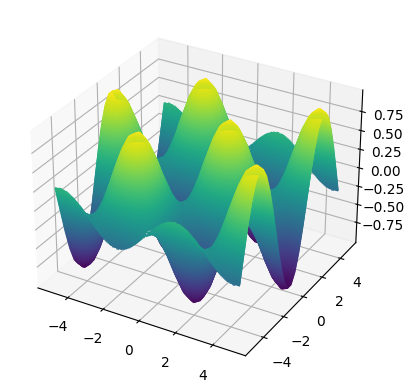

In [25]:
def f(x, y):
    return np.sin(x)*np.cos(y)

x_data = np.linspace(-5, 5, 30)
y_data = np.linspace(-5, 5, 30)

X, Y = np.meshgrid(x_data, y_data)
Z = f(X, Y)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 200)

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") 
dataset = Dataset(torch.tensor(x_data).float(), torch.tensor(y_data).float())

trainset, testset = torch.utils.data.random_split(dataset, [0.9, 0.1], generator=torch.Generator().manual_seed(42))

trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=False)

In [4]:
class Perceptron(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.activation = nn.Sigmoid()
        self.fc2 = nn.Linear(hidden_size, output_size, bias=False)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x

model = Perceptron(1, 1000, 1).to(device)

In [5]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.000001)

Epoch: [1/1000], loss: 0.0248
Epoch: [2/1000], loss: 0.0125
Epoch: [3/1000], loss: 0.0054
Epoch: [4/1000], loss: 0.0194
Epoch: [5/1000], loss: 0.0301
Epoch: [6/1000], loss: 0.0177
Epoch: [7/1000], loss: 0.0265
Epoch: [8/1000], loss: 0.0274
Epoch: [9/1000], loss: 0.0017
Epoch: [10/1000], loss: 0.0095
Epoch: [11/1000], loss: 0.0388
Epoch: [12/1000], loss: 0.0172
Epoch: [13/1000], loss: 0.0137
Epoch: [14/1000], loss: 0.0154
Epoch: [15/1000], loss: 0.0062
Epoch: [16/1000], loss: 0.0088
Epoch: [17/1000], loss: 0.0239
Epoch: [18/1000], loss: 0.0113
Epoch: [19/1000], loss: 0.0074
Epoch: [20/1000], loss: 0.0076
Epoch: [21/1000], loss: 0.0082
Epoch: [22/1000], loss: 0.0050
Epoch: [23/1000], loss: 0.0135
Epoch: [24/1000], loss: 0.0048
Epoch: [25/1000], loss: 0.0067
Epoch: [26/1000], loss: 0.0054
Epoch: [27/1000], loss: 0.0146
Epoch: [28/1000], loss: 0.0165
Epoch: [29/1000], loss: 0.0029
Epoch: [30/1000], loss: 0.0068
Epoch: [31/1000], loss: 0.0239
Epoch: [32/1000], loss: 0.0069
Epoch: [33/1000],

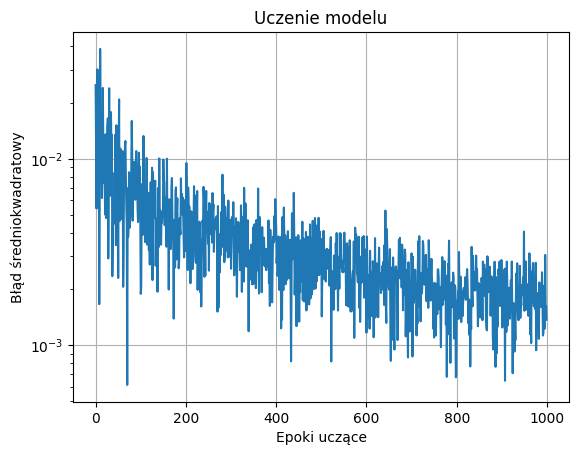

In [6]:
num_epochs = 1000
all_losses = []
model.train()

for epoch in range(num_epochs):
    for i, (x, y) in enumerate(trainloader):
        optimizer.zero_grad()
        x, y = x.reshape(-1, 1).to(device), y.reshape(-1, 1).to(device)
        preds = model(x)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
    all_losses.append(loss.item())
    print(f'Epoch: [{epoch+1}/{num_epochs}], loss: {loss.item():.4f}')

plt.plot(all_losses)
plt.yscale('log')
plt.title('Uczenie modelu')
plt.xlabel('Epoki uczące')
plt.ylabel('Błąd średniokwadratowy')
plt.grid()
plt.show()

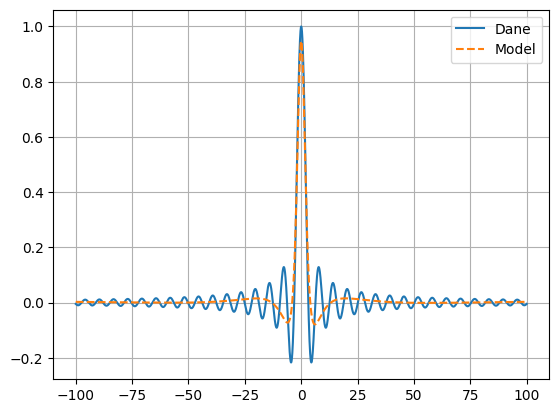

In [7]:
plt.plot(x_data, y_data)
plt.plot(x_data, model(torch.tensor(x_data).reshape(-1, 1).float().to(device)).cpu().detach().numpy(), '--')
plt.legend(['Dane', 'Model'], loc='upper right')
plt.grid()
plt.show()